# Phase 2 Group 1 Project

## Overview

## Business Problem

## Data Understanding

## Import

In [1]:
#import appropriate libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
pd.set_option('display.max_columns', None)
%matplotlib inline

## Review the Data File

In [2]:
#read in the file
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
#check the first 5 entries in the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#check the columns and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Cleaning the Data

In [5]:
#for year renovated, convert any houses that have been renovated to '1' to indicate true
#for any nulls, assume no renovation
df['yr_renovated'].fillna(0, inplace=True)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)

In [6]:
df.rename(columns={'yr_renovated': 'if_renovated'}, inplace=True)

In [7]:
#for any nulls, assume no waterfront
df['waterfront'].fillna(0, inplace=True)

In [8]:
#for any nulls, assume no one viewed the property
df['view'].fillna(0, inplace=True)

In [9]:
#clean up sqft_basement and convert to int
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)
df['sqft_basement'].fillna(df['sqft_living']-df['sqft_above'], inplace=True)

In [10]:
#retrieve the months and year
df['month_of_date'] = pd.DatetimeIndex(df['date']).month
df['year_of_date'] = pd.DatetimeIndex(df['date']).year

In [11]:
#convert yr_built to age of house by subtracting year the property was sold by the year it was built
#to create a more sensible column 
df['age_of_house'] = df['year_of_date'] - df['yr_built']

#drop year of date because years are only 2014 and 2015, and will not impact our predicative model
#drop yr_built b/c it is redundant with age_of_house
df.drop(columns=['year_of_date'], inplace=True)
df.drop(columns=['yr_built'], inplace=True)

In [12]:
#drop duplicates if any
df.drop_duplicates(inplace=True)

In [13]:
#drop id and date columns
df.drop(columns=['id'], inplace=True)
df.drop(columns=['date'], inplace=True)

In [14]:
#reset index
df.reset_index(inplace=True, drop=True)

In [15]:
#convert some of the categorical data from floats to ints
df['waterfront'] = df['waterfront'].astype(int)
df['view'] = df['view'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['if_renovated'] = df['if_renovated'].astype(int)

In [16]:
#check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  if_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

In [17]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,if_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,98178,47.5112,-122.257,1340,5650,10,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1,98125,47.7210,-122.319,1690,7639,12,63
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,98028,47.7379,-122.233,2720,8062,2,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,0,98136,47.5208,-122.393,1360,5000,12,49
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,98074,47.6168,-122.045,1800,7503,2,28


## EDA

### Target: Price

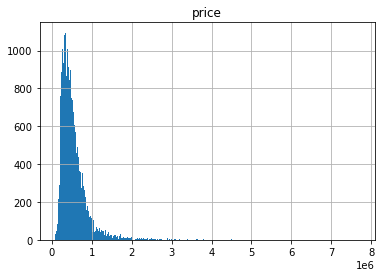

In [18]:
#Since price is our target, we will explore first
#view distribution of price using histogram
df.hist(column=['price'], bins='auto');

<AxesSubplot:>

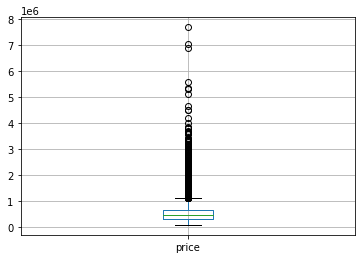

In [19]:
df.boxplot(column=['price'])

In [20]:
#Because the data is skewed to the right, transform the price data using log
df['ln_price'] = np.log(df['price'])

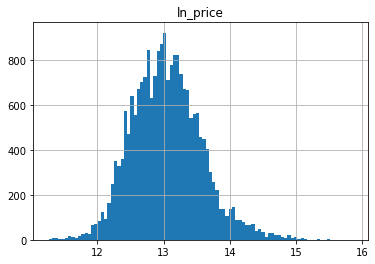

In [21]:
#view distribution of log base e for price using histogram
df.hist(column=['ln_price'], bins='auto');

<AxesSubplot:>

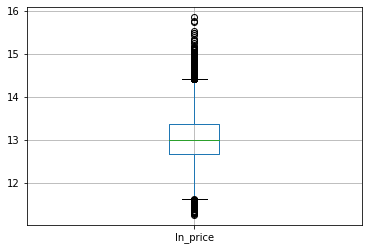

In [22]:
df.boxplot(column=['ln_price'])

### Predictors: Everything Else

In [23]:
#sns.pairplot(df)

In [24]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'if_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_of_date', 'age_of_house',
       'ln_price'],
      dtype='object')

In [25]:
#based on the pairplot, we can see which data are categorical and which are numeric
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

categorical = ['floors',
               'waterfront', 
               'view', 
               'condition', 
               'grade',
               'if_renovated',
               'zipcode',
               'month_of_date']

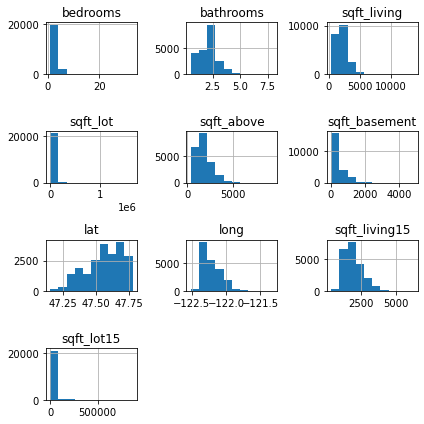

In [26]:
#plot the numeric parameters to see distribution
df[numeric].hist(figsize=[6,6]);
plt.tight_layout()
plt.show()

In [27]:
#log transform all numeric parameter except:
#sqft basement - has values of 0
#long - has negative values
to_ln = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above',
           'lat',
           'sqft_living15', 
           'sqft_lot15']

for column in to_ln:
    df[column] = np.log(df[column])

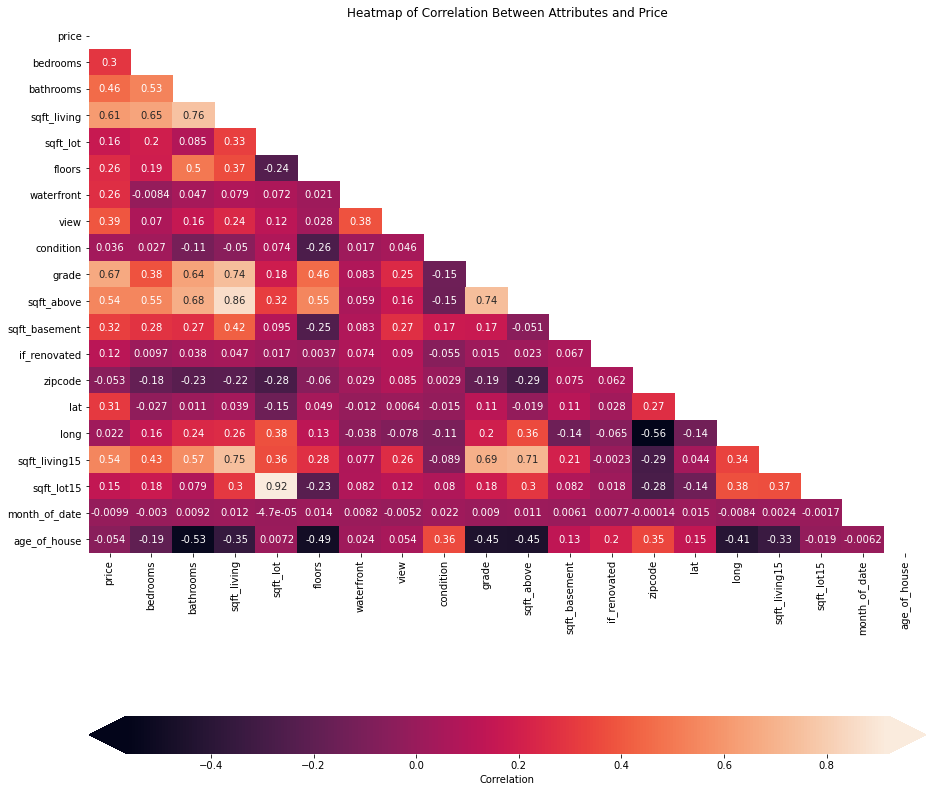

In [28]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
y = df['price']
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [29]:
#reporting the correlation between price (target) and predictors
df.corr()['price'].drop(['ln_price']).map(abs).sort_values(ascending=False)

price            1.000000
grade            0.667951
sqft_living      0.611839
sqft_living15    0.543829
sqft_above       0.542675
bathrooms        0.456122
view             0.393497
sqft_basement    0.323799
lat              0.306954
bedrooms         0.298844
waterfront       0.264306
floors           0.256804
sqft_lot         0.161561
sqft_lot15       0.147913
if_renovated     0.117543
age_of_house     0.053890
zipcode          0.053402
condition        0.036056
long             0.022036
month_of_date    0.009928
Name: price, dtype: float64

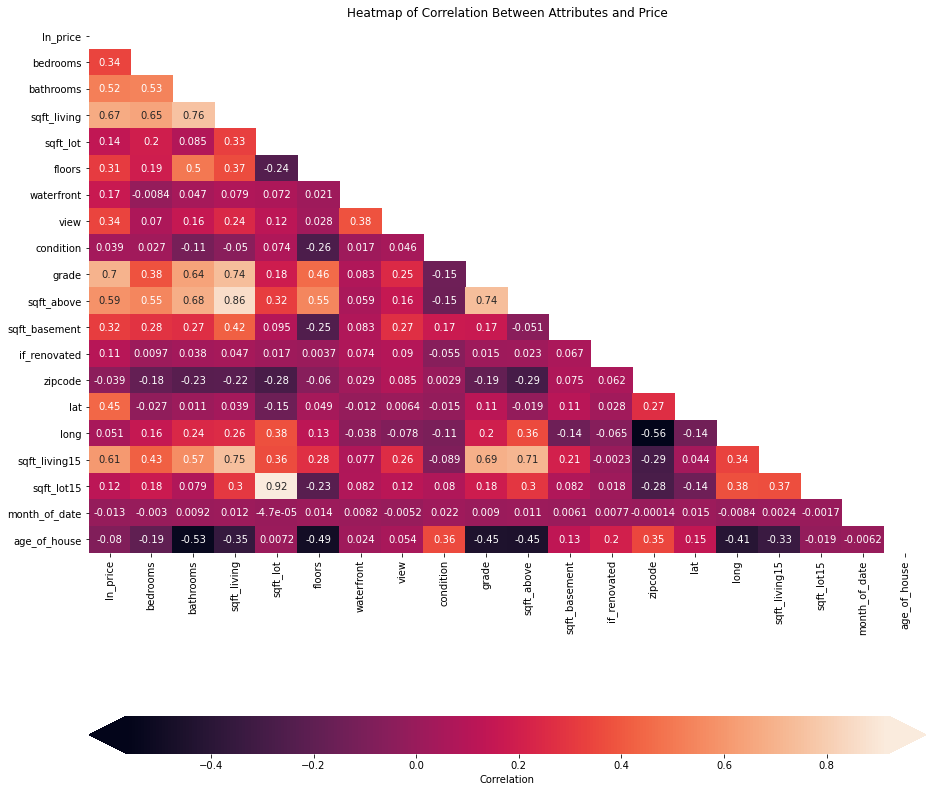

In [30]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
ln_y = df['ln_price']
heatmap_data = pd.concat([ln_y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [31]:
#reporting the correlation between ln price (target) and predictors
df.corr()['ln_price'].drop(['price']).map(abs).sort_values(ascending=False)

ln_price         1.000000
grade            0.703720
sqft_living      0.674802
sqft_living15    0.607154
sqft_above       0.586013
bathrooms        0.520278
lat              0.449133
view             0.344653
bedrooms         0.342850
sqft_basement    0.316920
floors           0.310630
waterfront       0.170720
sqft_lot         0.138261
sqft_lot15       0.123710
if_renovated     0.106528
age_of_house     0.080499
long             0.050862
condition        0.038918
zipcode          0.038788
month_of_date    0.013064
Name: ln_price, dtype: float64

## Data Mainipulation

In [32]:
#creating a copy of base data
output = df

#dummying out categoricals defined in cleaning section
output = pd.get_dummies(output, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

#replace '.' with '_' in column names since sklearn LR has issues with '.'
output.columns = [x.replace(".","_") for x in output.columns]

#dropping targets out of predictors
X = output.drop(['price','ln_price'], axis=1)

#non-log transformed y values
y = output['price']

#log transformed y-values
ln_y = output['ln_price']

#scaling X values into z-scores
#ss = StandardScaler()
#ss.fit(X)
#X_scaled = pd.DataFrame(ss.transform(X))

#scaling process loses the column names so we're adding back
#X_scaled.columns = X.columns

#creating universal train test split for model comparison
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train2, X_test2, ln_y_train, ln_y_test = train_test_split(X, ln_y, test_size=0.20, random_state=42)

## Formulas and useful objects

In [33]:
def cross_val(estimator,X=X,y=y,n_splits=10,test_size=0.25, random_state=None):
    """
    This formula performs cross validation using shuffled splits. Output is a tuple,
    The 0th element is the median R2 score for the train sets, the 1st element
    is the median R2 score for the test sets.
    
    """
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    output = cross_validate(estimator, X=X, y=y, cv=splitter, return_train_score=True)
    return np.median(output['train_score']), np.median(output['test_score'])

In [34]:
def cval_summary(train,test,diff):
    return f"The median R-squared values for the train sets were {round(train,3)}, the median R-squared values for the test sets were {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [35]:
def score_model(model,Xtrain,Xtest,ytrain,ytest):
    return model.score(Xtrain, ytrain), model.score(Xtest, ytest)

In [36]:
def model_summary(train,test,diff):
    return f"The R-squared value for the train set was {round(train,3)}, and the R-sqaured value for the test set was {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [1]:
def normality_test(ols_model):
    residuals = ols_model.resid
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    test = sms.jarque_bera(residuals)
    for name, test in zip(name, test):
        print('\n',name, '----')
        print(test)
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);
    fig.show();
    return(test[0])

In [2]:
def homoscedasticity_test(ols_model):
    predicted_y = ols_model.predict()
    resids = ols_model.resid

    fig, ax = plt.subplots()

    sns.regplot(x=predicted_y, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
    ax.set_title('Residuals vs Fitted', fontsize=16)
    ax.set(xlabel='Fitted Values', ylabel='Residuals')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, ols_model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, ols_model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plot ----')
    return(gg_test)

In [39]:
def predicted_vs_actual(model,X_test,y_test):
    y_predicted = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=y_test, y=y_predicted)
    ax.set_xlabel("Actual Price Values")
    ax.set_ylabel("Predicted Price Values")
    ax.set_title("Actual vs Predicted")
    
    p1 = max(max(y_test), max(y_predicted))
    p2 = min(min(y_test), min(y_predicted))
    plt.plot([p1, p2], [p1, p2], 'b-')

## Baseline Model

### Baseline: Target Price

In [40]:
#create a dummy regressor model based on the target as price
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train1,y_train);

In [41]:
#setting up cross validation for price in a different way (x3)
bmodel_cval = cross_val(baseline_model,
                        random_state=0)

bmodel_cval_summary = cval_summary(bmodel_cval[0],
                                   bmodel_cval[1],
                                   (abs(bmodel_cval[0]-bmodel_cval[1])))
bmodel_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00017'

In [42]:
baseline_scores = score_model(baseline_model,
                              X_train1,
                              X_test1,
                              y_train,
                              y_test)

baseline_summary = model_summary(baseline_scores[0],
                                 baseline_scores[1],
                                 abs(baseline_scores[0]-baseline_scores[1]))
baseline_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00029'

### Baseline: Target Log-transformed Price

In [43]:
#create `a dummy regressor model based on the target as price
baseline_ln_model = DummyRegressor(strategy='mean')
baseline_ln_model.fit(X_train2,ln_y_train);

In [44]:
bmodel_ln_cval = cross_val(baseline_ln_model,
                           y=ln_y,
                           random_state=0)

bmodel_ln_cval_summary = cval_summary(bmodel_ln_cval[0],
                                      bmodel_ln_cval[1], 
                                      abs(bmodel_ln_cval[0]-bmodel_ln_cval[1]))
bmodel_ln_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00029'

In [45]:
baseline_ln_scores = score_model(baseline_ln_model,
                                 X_train2,
                                 X_test2,
                                 ln_y_train,
                                 ln_y_test)

baseline_ln_summary = model_summary(baseline_ln_scores[0],
                                    baseline_ln_scores[1],
                                    abs(baseline_ln_scores[0]-baseline_ln_scores[1]))
baseline_ln_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00022'

### Summary

After running cross validation with both of our baseline models to ensure data integrity, we found from the results of our regression R-squared scores that the fit of the data we found that the cval, train and test scores were all near 0. This is to be expected of the baseline model due to it's horizontal nature. Exactly 0% of the variation in y train is predicted by a horizontal line through the mean and 100% of it is due to variance.

>The miniscule inscrease in R-squared for the test set is due to the slight change in mean from the train to test sets.

It is also worthwhile to mention that the log-transformed data performed slightly better on the test set than its non-transformed counterpart

## Model 1

Model 1 uses a multiple linear regression model of the data using all parameters, including the dummied out categorical parameters.

### Model 1: Target Price

In [46]:
#create linear regression model for price and setting up cross validation 
model1 = LinearRegression()
model1.fit(X_train1, y_train);

In [47]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                           random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.83, the median R-squared values for the test sets were 0.828. These values resulted in a differential of 0.00222'

In [48]:
model1_scores = score_model(model1,
                            X_train1,
                            X_test1,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]))
model1_summary

'The R-squared value for the train set was 0.838, and the R-sqaured value for the test set was 0.798. These values resulted in a differential of 0.03989'

### Model 1: Target Log-transformed Price

In [49]:
#create linear regression model for ln price
model1_ln= LinearRegression()
model1_ln.fit(X_train2, ln_y_train);

In [50]:
#setting up cross validation
model1_ln_cval = cross_val(model1_ln,
                           y = ln_y,
                           random_state=0)

model1_ln_cval_summary = cval_summary(model1_ln_cval[0],
                                   model1_ln_cval[1],
                                   abs(model1_ln_cval[0]-model1_ln_cval[1]))
model1_ln_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [51]:
#find the test score using the linear model
model1_ln_scores = score_model(model1_ln,
                             X_train2,
                             X_test2,
                             ln_y_train,
                             ln_y_test)

model1_ln_summary = model_summary(model1_ln_scores[0],
                                  model1_ln_scores[1],
                                  abs(model1_ln_scores[0]-model1_ln_scores[1]))
model1_ln_summary

'The R-squared value for the train set was 0.888, and the R-sqaured value for the test set was 0.885. These values resulted in a differential of 0.00362'

In [52]:
#given that the log-transformed price had a higher R-squared value, drop the untransformed price column going forward
output.drop(['price'], axis=1, inplace=True)

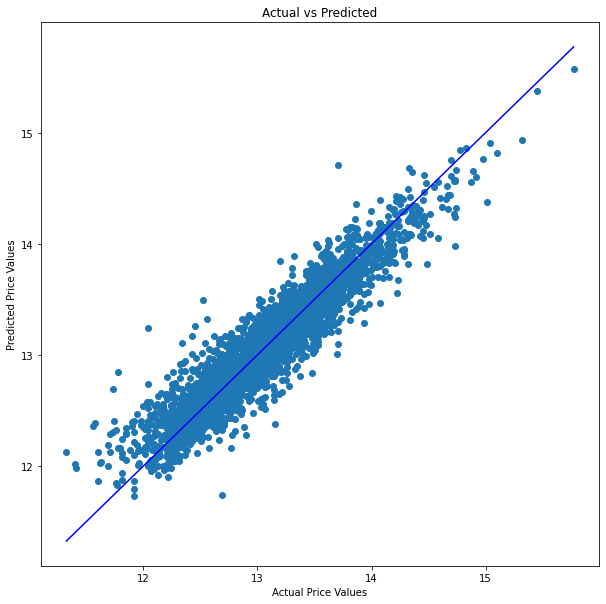

In [53]:
predicted_vs_actual(model1_ln, X_test2, ln_y_test)

### Model 1: OLS and Assumption Tests

In [54]:
#set target
target = 'ln_price'

#join the column names with "+"
columns= "+".join(output.drop(['ln_price'], axis=1).columns)

#set formula
formula = target + '~' + columns

#create the OLS
model1_ols = ols(formula, output).fit()

In [55]:
model1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1464.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:14:12   Log-Likelihood:                 6819.7
No. Observations:               21597   AIC:                        -1.341e+04
Df Residuals:                   21480   BIC:                        -1.247e+04
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -139.4554     13.859    -10.062      0.000    -166.621    -112.290
bedrooms            -0.0443      0.006     -7.381      0.000      -0.056      -0.033
bathrooms            0.0615      0.006     10.654      0.000       0.050       0.073
sqft_living          0.2832      0.017     16.225      0.000       0.249       0.317
sqft_lot             0.0738      0.004     20.611      0.000       0.067       0.081
sqft_above           0.1481      0.016      9.475      0.000       0.117       0.179
sqft_basement     5.472e-06   8.17e-06      0.670      0.503   -1.05e-05    2.15e-05
lat                 24.1197      3.323      7.259      0.000      17.607      30.633
long                -0.4434      0.051     -8.744      0.000      -0.543      -0.344
sqft_living15        0.1456      0.007     21.968      0.000       0.133       0.159
sqft_lot15          -0.0200      0.004     -5.070      0.000      -0.028      -0.012
age_of_house     -1.024e-05   7.89e-05     -0.130      0.897      -0.000       0.000
floors_1_5           0.0083      0.005      1.645      0.100      -0.002       0.018
floors_2_0          -0.0086      0.004     -1.995      0.046      -0.017      -0.000
floors_2_5           0.0092      0.015      0.620      0.535      -0.020       0.038
floors_3_0          -0.0818      0.009     -8.698      0.000      -0.100      -0.063
floors_3_5          -0.0702      0.067     -1.043      0.297      -0.202       0.062
waterfront_1         0.4415      0.018     24.166      0.000       0.406       0.477
view_1               0.1125      0.010     11.148      0.000       0.093       0.132
view_2               0.1023      0.006     16.588      0.000       0.090       0.114
view_3               0.1774      0.008     21.022      0.000       0.161       0.194
view_4               0.2898      0.013     22.741      0.000       0.265       0.315
condition_2          0.1546      0.036      4.322      0.000       0.085       0.225
condition_3          0.2869      0.033      8.609      0.000       0.222       0.352
condition_4          0.3288      0.033      9.862      0.000       0.263       0.394
condition_5          0.3986      0.034     11.879      0.000       0.333       0.464
grade_4             -0.5301      0.181     -2.933      0.003      -0.884      -0.176
grade_5             -0.5526      0.178     -3.107      0.002      -0.901      -0.204
grade_6             -0.4896      0.178     -2.757      0.006      -0.838      -0.142
grade_7             -0.4245      0.178     -2.390      0.017      -0.773      -0.076
grade_8             -0.3432      0.178     -1.931      0.053      -0.691       0.005
grade_9             -0.2257      0.178     -1.270      0.204      -0.574       0.123
grade_10            -0.1310      0.178     -0.737      0.461      -0.480       0.218
grade_11            -0.


 Jarque-Bera ----
7008.373805527755

 Prob ----
0.0

 Skew ----
-0.24519736714095344

 Kurtosis ----
5.7473035325811175


<ipython-input-37-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


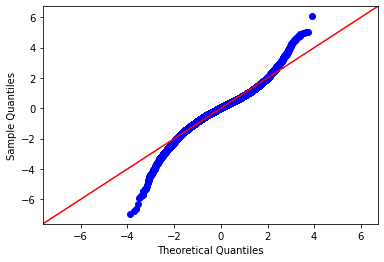

In [56]:
#test for normality
normality_test(model1_ols)


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  2191.784606
p-value                           0.000000
f-value                          20.914895
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.976657
p-value      0.888869

 Residuals plot ----


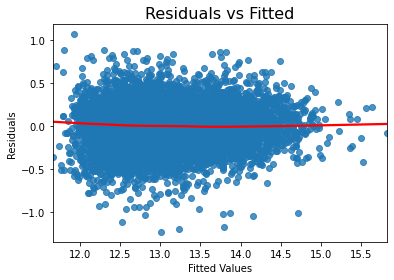

In [57]:
#test for homoscedasticity
homoscedasticity_test(model1_ols)

### Summary

We see that both variations of Model 1 output a higher R-squared than value than either of the Baseline models with values ranging between 0.810 and 0.880. In addition, Model 1 train and test scores varied by less than 5%. 

>The version of Model 1 that used the log-transformed price data had a .07 higher R-squared value than the untransformed price data model as well as a  .03 lower differential between train and test sets. For this reason we are going to stop using the regular price data and move forward with the transformed data.

The cross validation performed identically between these two features and did not drastically differ from our test statistics (R-squared).

In [58]:
#Overwriting non-transformed train/test splits, to avoid confusion we will switch to simpler names
X_train = X_train2
X_test = X_test2
y_train = ln_y_train
y_test = ln_y_test

## Model 2

In Model 2 we drop features that had a relatively high p-value (alpha = 0.05) from Model 1 OLS to look for improvement in model fit.

### Model 2: Filtering by p-value

In [59]:
#create a dataframe for the parameters and pvalues
results = pd.DataFrame(model1_ols.pvalues)
results.reset_index(inplace=True)

#rename the columns
results.rename(columns={'index': 'parameter', 0: 'pvalue'}, inplace=True)

#create a list of parameters that have a pvalue < 0.05
parameters = list(results[results['pvalue'] < 0.05]['parameter'])

#the intercept parameter is not needed 
parameters.remove('Intercept')

### Model 2: Fitting and Validation

In [60]:
#create linear regression model for price and setting up cross validation (x3)
model2 = LinearRegression()
model2.fit(X_train[parameters], y_train);

In [61]:
#setting up cross validation
model2_cval = cross_val(model2,
                        y=ln_y,
                        random_state=0)

model2_cval_summary = cval_summary(model2_cval[0],
                                   model2_cval[1],
                                   abs(model2_cval[0]-model2_cval[1]))
model2_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [62]:
#find the test score using the linear model
model2_scores = score_model(model2,
                             X_train[parameters],
                             X_test[parameters],
                             y_train,
                             y_test)

model2_summary = model_summary(model2_scores[0],
                                  model2_scores[1],
                                  abs(model2_scores[0]-model2_scores[1]))
model2_summary

'The R-squared value for the train set was 0.878, and the R-sqaured value for the test set was 0.873. These values resulted in a differential of 0.00514'

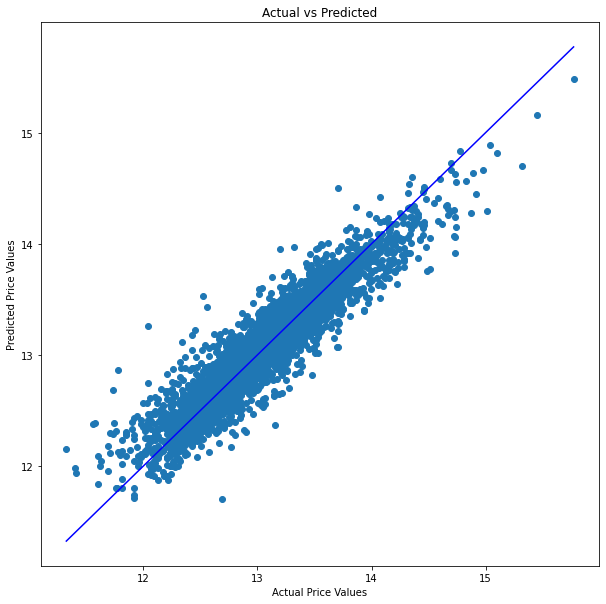

In [63]:
predicted_vs_actual(model2, X_test[parameters], y_test)

### Model 2: OLS and Assumption Tests

In [64]:
#set target
target = 'ln_price'

#join the column names with "+"
columns= "+".join(output[parameters].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model2_ols = ols(formula, output).fit()

In [65]:
print(model2_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1650.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:14:34   Log-Likelihood:                 5843.5
No. Observations:               21597   AIC:                        -1.150e+04
Df Residuals:                   21503   BIC:                        -1.075e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -140.3638     10.184    -


 Jarque-Bera ----
5228.342078579807

 Prob ----
0.0

 Skew ----
-0.14170924361935497

 Kurtosis ----
5.39368959814792


<ipython-input-37-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


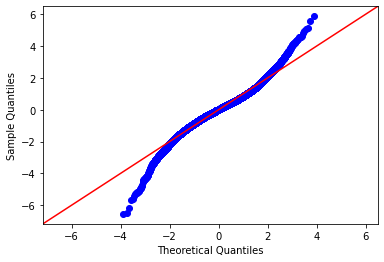

In [66]:
#test for normality
normality_test(model2_ols)


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  2152.457185
p-value                           0.000000
f-value                          25.594868
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.982981
p-value      0.812727

 Residuals plot ----


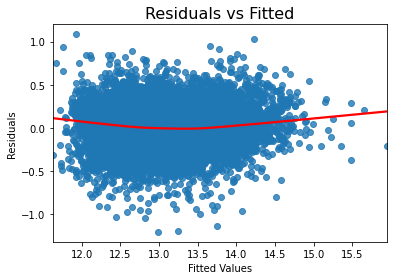

In [67]:
#test for homoscedasticity
homoscedasticity_test(model2_ols)

### Summary

Our fit on the data has dropped drastically by removing features containing p-values greater than 0.05. In light of this signifigant decrease in accuracy we will still be relying on our "best model", which is currently model 1.

## Model 3

Model 3 uses the same dataframe structure as Model 1, but introduces recursive feature elimination (RFE) of varying n_parameters  to improve on the model.

### Model 3: Recursive Feature Elimination (RFE)

In [68]:
#determine how many features we have
len(X_train.columns)

116

In [69]:
#determine n for REF
n = [10, 20, 50, 100]

key_cols = {}

for x in n:
    #instatiate Linear Regression
    lr_rfe = LinearRegression()
    select = RFE(lr_rfe, n_features_to_select=x)
    
    #fit model to RFE
    select.fit(X=X_train, y=y_train)
    
    #obtain the indexes where select.support_ is true
    true_indexes = [i for i, x in enumerate(select.support_) if x]
    
    #create a list of all column names matched with index and add to dictionary
    key_columns = []
    for i in true_indexes:
        key_columns.append(X_train.columns[i])
    key_cols["key_cols_{0}".format(x)] = key_columns 

In [70]:
X_train[key_cols['key_cols_10']].shape

(17277, 10)

### Model 3: Testing 10 Features

In [71]:
#create linear regression model for price and setting up cross validation (x3)
model3_10 = LinearRegression()
model3_10.fit(X_train[key_cols['key_cols_10']], y_train);

In [72]:
#setting up cross validation for price in a different way (x3)
model3_10_cval = cross_val(model3_10,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_10_cval_summary = cval_summary(model3_10_cval[0],
                                   model3_10_cval[1],
                                   abs(model3_10_cval[0]-model3_10_cval[1]))

model3_10_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [73]:
#find the test score using the linear model
model3_10_scores = score_model(model3_10,
                           X_train[key_cols['key_cols_10']],
                           X_test[key_cols['key_cols_10']],
                           y_train,
                           y_test)

model3_10_summary = model_summary(model3_10_scores[0],
                              model3_10_scores[1],
                              abs(model3_10_scores[0]-model3_10_scores[1]))
model3_10_summary

'The R-squared value for the train set was 0.712, and the R-sqaured value for the test set was 0.707. These values resulted in a differential of 0.00509'

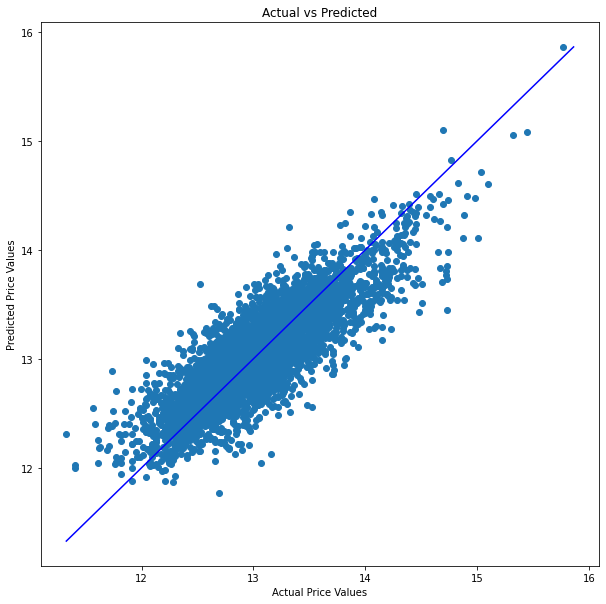

In [74]:
predicted_vs_actual(model3_10, X_test[key_cols['key_cols_10']], y_test)

In [75]:
#set target
target = 'ln_price'

#join the column names with "+"
columns= "+".join(output[key_cols['key_cols_10']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_10_ols = ols(formula, output).fit()

In [76]:
print(model3_10_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     5321.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:15:21   Log-Likelihood:                -3372.3
No. Observations:               21597   AIC:                             6767.
Df Residuals:                   21586   BIC:                             6854.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -274.8020      2.565   -107.127


 Jarque-Bera ----
314.5092938849914

 Prob ----
5.071945511586353e-69

 Skew ----
0.09219158294216882

 Kurtosis ----
3.5616993512980173


<ipython-input-37-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


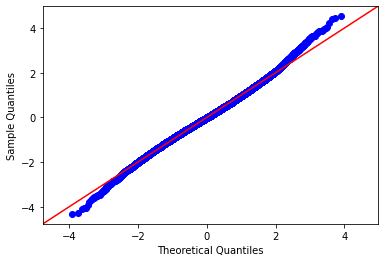

In [77]:
#test for normality
normality_test(model3_10_ols)


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  4.124843e+02
p-value                        2.069834e-82
f-value                        4.203016e+01
f p-value                      3.125739e-83

 Goldfeld-Quandt test ----
                value
F statistic  0.947720
p-value      0.997351

 Residuals plot ----


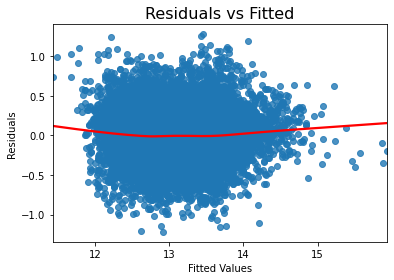

In [78]:
#test for homoscedasticity
homoscedasticity_test(model3_10_ols)

### Model 3: Testing 20 Features

In [79]:
#create linear regression model for price and setting up cross validation (x3)
model3_20 = LinearRegression()
model3_20.fit(X_train[key_cols['key_cols_20']], y_train);

In [80]:
#setting up cross validation for price in a different way (x3)
model3_20_cval = cross_val(model3_20,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_20_cval_summary = cval_summary(model3_20_cval[0],
                                   model3_20_cval[1],
                                   abs(model3_20_cval[0]-model3_20_cval[1]))

model3_20_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [81]:
#find the test score using the linear model
model3_20_scores = score_model(model3_20,
                           X_train[key_cols['key_cols_20']],
                           X_test[key_cols['key_cols_20']],
                           y_train,
                           y_test)

model3_20_summary = model_summary(model3_20_scores[0],
                              model3_20_scores[1],
                              abs(model3_20_scores[0]-model3_20_scores[1]))
model3_20_summary

'The R-squared value for the train set was 0.773, and the R-sqaured value for the test set was 0.762. These values resulted in a differential of 0.01099'

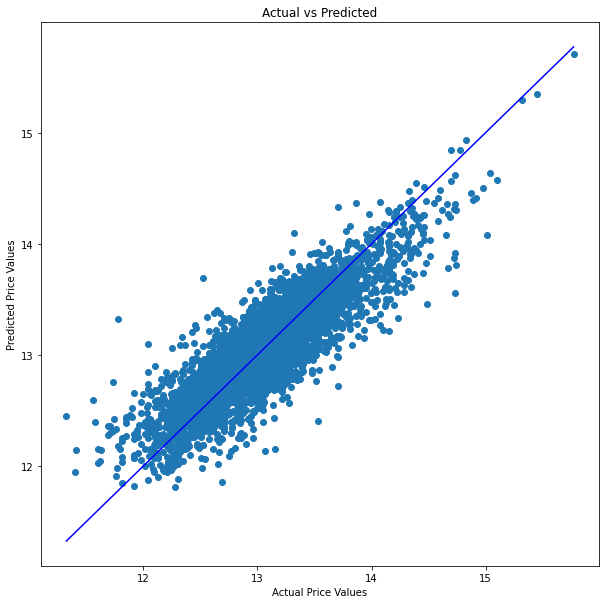

In [82]:
predicted_vs_actual(model3_20, X_test[key_cols['key_cols_20']], y_test)

In [83]:
#set target
target = 'ln_price'

#join the column names with "+"
columns= "+".join(output[key_cols['key_cols_20']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_20_ols = ols(formula, output).fit()

In [84]:
print(model3_20_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     3630.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:15:46   Log-Likelihood:                -879.98
No. Observations:               21597   AIC:                             1802.
Df Residuals:                   21576   BIC:                             1970.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -246.1708      2.348   -104.845


 Jarque-Bera ----
749.6600715196074

 Prob ----
1.6344958337361332e-163

 Skew ----
0.08934658475727973

 Kurtosis ----
3.895064294083569


<ipython-input-37-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


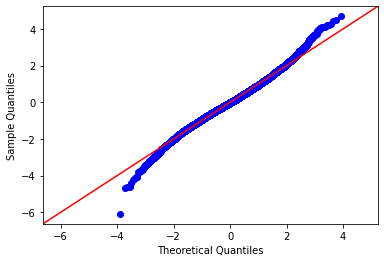

In [85]:
#test for normality
normality_test(model3_20_ols)


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  3.547149e+02
p-value                        4.753446e-63
f-value                        1.801437e+01
f p-value                      1.290100e-63

 Goldfeld-Quandt test ----
                value
F statistic  0.957098
p-value      0.988576

 Residuals plot ----


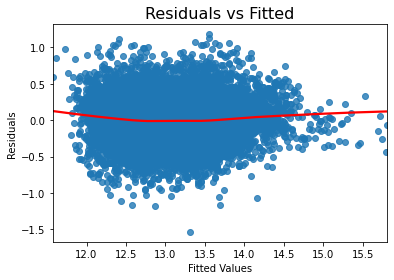

In [86]:
#test for homoscedasticity
homoscedasticity_test(model3_20_ols)

### Model 3: Testing 50 Features

In [87]:
#create linear regression model for price and setting up cross validation (x3)
model3_50 = LinearRegression()
model3_50.fit(X_train[key_cols['key_cols_50']], y_train);

In [88]:
#setting up cross validation for price in a different way (x3)
model3_50_cval = cross_val(model3_50,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_50_cval_summary = cval_summary(model3_50_cval[0],
                                   model3_50_cval[1],
                                   abs(model3_50_cval[0]-model3_50_cval[1]))

model3_50_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [89]:
#find the test score using the linear model
model3_50_scores = score_model(model3_50,
                           X_train[key_cols['key_cols_50']],
                           X_test[key_cols['key_cols_50']],
                           y_train,
                           y_test)

model3_50_summary = model_summary(model3_50_scores[0],
                              model3_50_scores[1],
                              abs(model3_50_scores[0]-model3_50_scores[1]))
model3_50_summary

'The R-squared value for the train set was 0.86, and the R-sqaured value for the test set was 0.854. These values resulted in a differential of 0.00588'

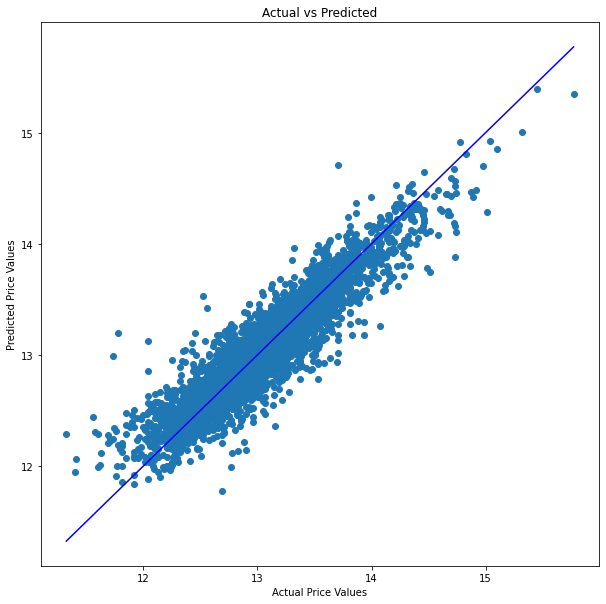

In [90]:
predicted_vs_actual(model3_50, X_test[key_cols['key_cols_50']], y_test)

In [91]:
#set target
target = 'ln_price'

#join the column names with "+"
columns= "+".join(output[key_cols['key_cols_50']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_50_ols = ols(formula, output).fit()

In [92]:
model3_50_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     2624.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:16:13   Log-Likelihood:                 4357.4
No. Observations:               21597   AIC:                            -8613.
Df Residuals:                   21546   BIC:                            -8206.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -190.9792      2.132    -89.581      0.000    -195.158    -186.801
sqft_living       0.4522      0.006     82.217      0.000       0.441       0.463
lat              51.5785      0.552     93.474      0.000      50.497      52.660
sqft_living15     0.1990      0.007     28.939      0.000       0.186       0.213
waterfront_1      0.4579      0.020     22.527      0.000       0.418       0.498
view_3            0.1690      0.009     18.422      0.000       0.151       0.187
view_4            0.2944      0.014     21.130      0.000       0.267       0.322
grade_4          -0.4175      0.039    -10.587      0.000      -0.495      -0.340
grade_5          -0.4463      0.015    -28.795      0.000      -0.477      -0.416
grade_6          -0.3912      0.009    -42.172      0.000      -0.409      -0.373
grade_7          -0.3388      0.007    -46.851      0.000      -0.353      -0.325
grade_8          -0.2655      0.007    -40.646      0.000      -0.278      -0.253
grade_9          -0.1397      0.007    -21.170      0.000      -0.153      -0.127
grade_12          0.2455      0.022     11.230      0.000       0.203       0.288
grade_13          0.5697      0.056     10.252      0.000       0.461       0.679
zipcode_98004     0.7661      0.012     66.612      0.000       0.744       0.789
zipcode_98005     0.3834      0.016     24.694      0.000       0.353       0.414
zipcode_98006     0.3415      0.009     36.619      0.000       0.323       0.360
zipcode_98007     0.2920      0.017     17.339      0.000       0.259       0.325
zipcode_98008     0.3052      0.012     25.441      0.000       0.282       0.329
zipcode_98010     0.2383      0.020     11.900      0.000       0.199       0.278
zipcode_98022     0.2089      0.014     15.325      0.000       0.182       0.236
zipcode_98024     0.2127      0.022      9.561      0.000       0.169       0.256
zipcode_98027     0.2526      0.010     25.205      0.000       0.233       0.272
zipcode_98029     0.2735      0.011     24.108      0.000       0.251       0.296
zipcode_98033     0.3575      0.010     35.982      0.000       0.338       0.377
zipcode_98039     0.9561      0.028     33.735      0.000       0.901       1.012
zipcode_98040     0.5991      0.012     49.110      0.000       0.575       0.623
zipcode_98045     0.1554      0.014     11.501      0.000       0.129       0.182
zipcode_98052     0.1869      0.009     21.296      0.000       0.170       0.204
zipcode_98053     0.1621      0.010     15.737      0.000       0.142       0.182
zipcode_98070     0.2758      0.019     14.739      0.000       0.239       0.313
zipcode_98074     0.1585      0.010     16.040      0.000       0.139       0.178
zipcode_98075     0.2064      0.011     18.805      0.000       0.185       0.228
zipcode_98102     0.5578      0.020     28.399   


 Jarque-Bera ----
4150.191583964392

 Prob ----
0.0

 Skew ----
-0.07924615028329161

 Kurtosis ----
5.141692023488281


<ipython-input-37-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


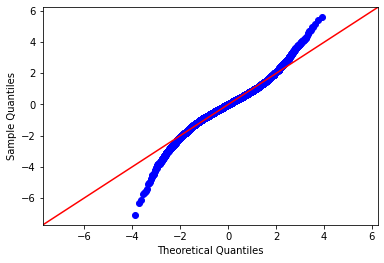

In [93]:
#test for normality
normality_test(model3_50_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.190592e+03
p-value                        1.927140e-216
f-value                         2.514161e+01
f p-value                      3.162035e-223

 Goldfeld-Quandt test ----
                value
F statistic  0.954202
p-value      0.992448

 Residuals plot ----


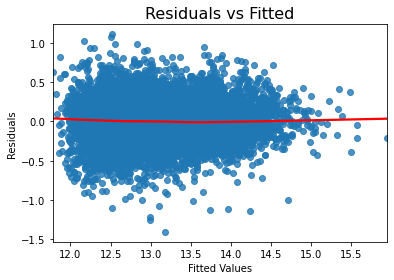

In [94]:
#test for homoscedasticity
homoscedasticity_test(model3_50_ols)

### Model 3: Testing 100 Features

In [95]:
#create linear regression model for price and setting up cross validation (x3)
model3_100 = LinearRegression()
model3_100.fit(X_train[key_cols['key_cols_100']], y_train);

In [96]:
#setting up cross validation for price in a different way (x3)
model3_100_cval = cross_val(model3_100,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_100_cval_summary = cval_summary(model3_100_cval[0],
                                   model3_100_cval[1],
                                   abs(model3_100_cval[0]-model3_100_cval[1]))

model3_100_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [97]:
#find the test score using the linear model
model3_100_scores = score_model(model3_100,
                           X_train[key_cols['key_cols_100']],
                           X_test[key_cols['key_cols_100']],
                           y_train,
                           y_test)

model3_100_summary = model_summary(model3_100_scores[0],
                              model3_100_scores[1],
                              abs(model3_100_scores[0]-model3_100_scores[1]))
model3_100_summary

'The R-squared value for the train set was 0.888, and the R-sqaured value for the test set was 0.885. These values resulted in a differential of 0.00355'

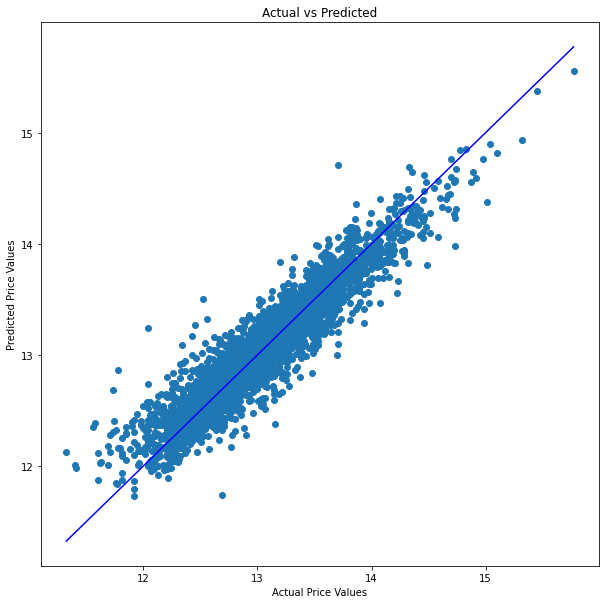

In [98]:
predicted_vs_actual(model3_100, X_test[key_cols['key_cols_100']], y_test)

In [99]:
#set target
target = 'ln_price'

#join the column names with "+"
columns= "+".join(output[key_cols['key_cols_100']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_100_ols = ols(formula, output).fit()

In [100]:
model3_100_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1697.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:16:35   Log-Likelihood:                 6808.1
No. Observations:               21597   AIC:                        -1.341e+04
Df Residuals:                   21496   BIC:                        -1.261e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -135.7032     10.487    -12.940      0.000    -156.258    -115.148
bedrooms           -0.0422      0.006     -7.086      0.000      -0.054      -0.031
bathrooms           0.0573      0.005     10.796      0.000       0.047       0.068
sqft_living         0.2970      0.008     37.148      0.000       0.281       0.313
sqft_lot            0.0749      0.004     21.384      0.000       0.068       0.082
sqft_above          0.1339      0.007     20.310      0.000       0.121       0.147
lat                23.0262      2.401      9.592      0.000      18.321      27.731
long               -0.4470      0.050     -8.951      0.000      -0.545      -0.349
sqft_living15       0.1451      0.007     21.971      0.000       0.132       0.158
sqft_lot15         -0.0199      0.004     -5.055      0.000      -0.028      -0.012
floors_3_0         -0.0760      0.008     -9.281      0.000      -0.092      -0.060
floors_3_5         -0.0638      0.067     -0.950      0.342      -0.195       0.068
waterfront_1        0.4411      0.018     24.165      0.000       0.405       0.477
view_1              0.1137      0.010     11.303      0.000       0.094       0.133
view_2              0.1030      0.006     16.794      0.000       0.091       0.115
view_3              0.1791      0.008     21.457      0.000       0.163       0.196
view_4              0.2919      0.013     23.074      0.000       0.267       0.317
condition_2         0.1539      0.036      4.302      0.000       0.084       0.224
condition_3         0.2857      0.033      8.576      0.000       0.220       0.351
condition_4         0.3291      0.033      9.874      0.000       0.264       0.394
condition_5         0.3994      0.034     11.912      0.000       0.334       0.465
grade_4            -0.5150      0.037    -14.066      0.000      -0.587      -0.443
grade_5            -0.5387      0.017    -32.102      0.000      -0.572      -0.506
grade_6            -0.4757      0.012    -38.631      0.000      -0.500      -0.452
grade_7            -0.4105      0.011    -37.731      0.000      -0.432      -0.389
grade_8            -0.3300      0.010    -32.471      0.000      -0.350      -0.310
grade_9            -0.2136      0.010    -21.512      0.000      -0.233      -0.194
grade_10           -0.1187      0.010    -11.377      0.000      -0.139      -0.098
grade_12            0.1454      0.021      6.945      0.000       0.104       0.186
grade_13            0.4226      0.050      8.405      0.000       0.324       0.521
if_renovated_1      0.0734      0.007     10.836      0.000       0.060       0.087
zipcode_98002       0.0213      0.015      1.465      0.143      -0.007       0.050
zipcode_98004       1.0096      0.018     56.133      0.000       0.974       1.045
zipcode_98005       0.6308      0.021     30.357      0.000


 Jarque-Bera ----
7018.15672011703

 Prob ----
0.0

 Skew ----
-0.24062472645426214

 Kurtosis ----
5.750896958200598


<ipython-input-37-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


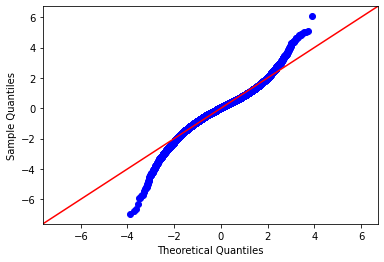

In [101]:
#test for normality
normality_test(model3_100_ols)


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  2121.359369
p-value                           0.000000
f-value                          23.414244
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.975039
p-value      0.904423

 Residuals plot ----


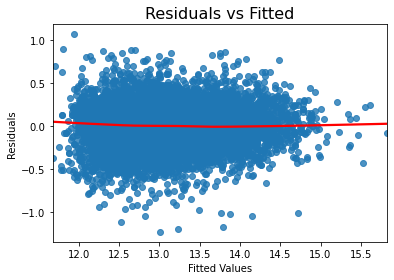

In [102]:
#test for homoscedasticity
homoscedasticity_test(model3_100_ols)

### Model 3: Summary

In [103]:
print(f"10 features {model3_10_scores,(model3_10_scores[0]-model3_10_scores[1])}"),print(f"20 features {model3_20_scores,(model3_20_scores[0]-model3_20_scores[1])}"),print(f"50 features {model3_50_scores,(model3_50_scores[0]-model3_50_scores[1])}"),print(f"100 features {model3_100_scores,(model3_100_scores[0]-model3_100_scores[1])}"),print(f" Previous Best Model{model1_ln_scores,(model1_ln_scores[0]-model1_ln_scores[1])}")

10 features ((0.7123611922720557, 0.7072726750549063), 0.005088517217149424)
20 features ((0.7729484932511164, 0.7619555439292492), 0.010992949321867118)
50 features ((0.8599459271865626, 0.8540682407154585), 0.005877686471104093)
100 features ((0.8881025021450206, 0.8845530288416648), 0.0035494733033558656)
 Previous Best Model((0.8882149191455073, 0.8845965056125005), 0.003618413533006848)


(None, None, None, None, None)

Looking at the score results above it becomes apparent that the trade off for removing features from our original model is a reduced R-squared statistic. It is interesting to note however, that although the 100 feature model's r-squared statistic worsened by a minisule amount, the differental between train and test was also more narrow. This trend continues down to 50 features and then the differential begins to rise again signaling that there may be some "best" number of features for balance between r-squared and the spread between test and train.

## Model 4

insert descriptive text on Binomial Feature Engineering 

### Model 4: Binomial Feature Engineering

In [105]:
#setting up binomial features from Train/Test split that uses ln_price as a y value
pf = PolynomialFeatures(degree=2)
pf.fit(X);

In [106]:
#Training/tranforming the data using the fit pf object. Formatting as DataFrame for ease of use
pdf_train = pd.DataFrame(pf.transform(X_train), columns = pf.get_feature_names())
pdf_test = pd.DataFrame(pf.transform(X_test), columns = pf.get_feature_names())

### Model 4: Pearson Correlation Coefficient Filtering

In [107]:
#calculating corr to the df with polynomial features to the train y values 
correlations = pdf_train.corrwith(y_train)
correlations_df = pd.DataFrame(correlations)
correlations_df.head()

,0
1,NaN
x0,0.012849
x1,0.006988
x2,0.007985
x3,0.005303


In [108]:
#NaN values represent columns containing 0 values, we wont need to consider these
correlations_df.dropna(inplace=True)

In [109]:
#Mapping absolute value over the correlations_df to allow us to find the most impactful coefs
correlations_df[0].map(abs)
#Sorting them so that we can skim the best ones off the top
correlations_df.sort_values(by=0,ascending=False,inplace=True)

In [110]:
#Column names of the top x number of features from our polynomial df, adding 1 to represent the intercept
features = list(correlations_df.index[:500]) + ['1']

### Model 4: Recursive Feature Elimination

In [111]:
#recrusive selector selects x numver of values from remaining features
select = RFE(lr_rfe, n_features_to_select=500)
select.fit(X = pdf_train[features], y = y_train);

In [112]:
#compiling a list of the selected features
pdf_keepers = [x[0] for x in zip(pdf_train.columns,select.support_) 
               if x[1] == True]

### Model 4: Model Validation

In [113]:
#instantiating a linear regression object
model4 = LinearRegression()
model4.fit(X = pdf_train[pdf_keepers], y = y_train);

In [114]:
model4_cval = cross_val(model4,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model4_cval_summary = cval_summary(model4_cval[0],
                                   model4_cval[1],
                                   abs(model4_cval[0]-model4_cval[1]))

model4_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [115]:
model4_scores = score_model(model4,
                           pdf_train[pdf_keepers ],
                           pdf_test[pdf_keepers ],
                           y_train,
                           y_test)

model4_summary = model_summary(model4_scores[0],
                              model4_scores[1],
                              abs(model4_scores[0]-model4_scores[1]))
model4_summary

'The R-squared value for the train set was 0.899, and the R-sqaured value for the test set was 0.89. These values resulted in a differential of 0.00945'

### Model 4: OLS and Assumption Tests

In [116]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([pdf_train[pdf_keepers], y_train], axis=1)

#replace '.' with '_' in column names since sklearn LR has issues with '.'
train.columns = [x.replace(" ","_") for x in train.columns]

#replace '.' with '_' in column names since sklearn LR has issues with '.'
pdf_train.columns = [x.replace(" ","_") for x in pdf_train.columns]

#join the column names with "+"
columns= "+".join(train.drop(['ln_price'], axis=1).columns)

#set formula
formula = target + '~' +columns

#create the OLS
#model4_ols = ols(formula, pdf_train).fit()

PatsyError: Error evaluating factor: TypeError: Cannot perform 'xor' with a dtyped [float64] array and scalar of type [bool]
    ln_price~1+x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15+x16+x17+x18+x19+x20+x21+x22+x23+x24+x25+x26+x27+x28+x29+x30+x31+x32+x33+x34+x35+x36+x37+x38+x39+x40+x41+x42+x43+x44+x45+x46+x47+x48+x49+x50+x51+x52+x53+x54+x55+x56+x57+x58+x59+x60+x61+x62+x63+x64+x65+x66+x67+x68+x69+x70+x71+x72+x73+x74+x75+x76+x77+x78+x79+x80+x81+x82+x83+x84+x85+x86+x87+x88+x89+x90+x91+x92+x93+x94+x95+x96+x97+x98+x99+x100+x101+x102+x103+x104+x105+x106+x107+x108+x109+x110+x111+x112+x113+x114+x115+x0^2+x0_x1+x0_x2+x0_x3+x0_x4+x0_x5+x0_x6+x0_x7+x0_x8+x0_x9+x0_x10+x0_x11+x0_x12+x0_x13+x0_x14+x0_x15+x0_x16+x0_x17+x0_x18+x0_x19+x0_x20+x0_x21+x0_x22+x0_x23+x0_x24+x0_x25+x0_x26+x0_x27+x0_x28+x0_x29+x0_x30+x0_x31+x0_x32+x0_x33+x0_x34+x0_x35+x0_x36+x0_x37+x0_x38+x0_x39+x0_x40+x0_x41+x0_x42+x0_x43+x0_x44+x0_x45+x0_x46+x0_x47+x0_x48+x0_x49+x0_x50+x0_x51+x0_x52+x0_x53+x0_x54+x0_x55+x0_x56+x0_x57+x0_x58+x0_x59+x0_x60+x0_x61+x0_x62+x0_x63+x0_x64+x0_x65+x0_x66+x0_x67+x0_x68+x0_x69+x0_x70+x0_x71+x0_x72+x0_x73+x0_x74+x0_x75+x0_x76+x0_x77+x0_x78+x0_x79+x0_x80+x0_x81+x0_x82+x0_x83+x0_x84+x0_x85+x0_x86+x0_x87+x0_x88+x0_x89+x0_x90+x0_x91+x0_x92+x0_x93+x0_x94+x0_x95+x0_x96+x0_x97+x0_x98+x0_x99+x0_x100+x0_x101+x0_x102+x0_x103+x0_x104+x0_x105+x0_x106+x0_x107+x0_x108+x0_x109+x0_x110+x0_x111+x0_x112+x0_x113+x0_x114+x0_x115+x1^2+x1_x2+x1_x3+x1_x4+x1_x5+x1_x6+x1_x7+x1_x8+x1_x9+x1_x10+x1_x11+x1_x12+x1_x13+x1_x14+x1_x15+x1_x16+x1_x17+x1_x18+x1_x19+x1_x20+x1_x21+x1_x22+x1_x23+x1_x24+x1_x25+x1_x26+x1_x27+x1_x28+x1_x29+x1_x30+x1_x31+x1_x32+x1_x33+x1_x34+x1_x35+x1_x36+x1_x37+x1_x38+x1_x39+x1_x40+x1_x41+x1_x42+x1_x43+x1_x44+x1_x45+x1_x46+x1_x47+x1_x48+x1_x49+x1_x50+x1_x51+x1_x52+x1_x53+x1_x54+x1_x55+x1_x56+x1_x57+x1_x58+x1_x59+x1_x60+x1_x61+x1_x62+x1_x63+x1_x64+x1_x65+x1_x66+x1_x67+x1_x68+x1_x69+x1_x70+x1_x71+x1_x72+x1_x73+x1_x74+x1_x75+x1_x76+x1_x77+x1_x78+x1_x79+x1_x80+x1_x81+x1_x82+x1_x83+x1_x84+x1_x85+x1_x86+x1_x87+x1_x88+x1_x89+x1_x90+x1_x91+x1_x92+x1_x93+x1_x94+x1_x95+x1_x96+x1_x97+x1_x98+x1_x99+x1_x100+x1_x101+x1_x102+x1_x103+x1_x104+x1_x105+x1_x106+x1_x107+x1_x108+x1_x109+x1_x110+x1_x111+x1_x112+x1_x113+x1_x114+x1_x115+x2^2+x2_x3+x2_x4+x2_x5+x2_x6+x2_x7+x2_x8+x2_x9+x2_x10+x2_x11+x2_x12+x2_x13+x2_x14+x2_x15+x2_x16+x2_x17+x2_x18+x2_x19+x2_x20+x2_x21+x2_x22+x2_x23+x2_x24+x2_x25+x2_x26+x2_x27+x2_x28+x2_x29+x2_x30+x2_x31+x2_x32+x2_x33+x2_x34+x2_x35+x2_x36+x2_x37+x2_x38+x2_x39+x2_x40+x2_x41+x2_x42+x2_x43+x2_x44+x2_x45+x2_x46+x2_x47+x2_x48+x2_x49+x2_x50+x2_x51+x2_x52+x2_x53+x2_x54+x2_x55+x2_x56+x2_x57+x2_x58+x2_x59+x2_x60+x2_x61+x2_x62+x2_x63+x2_x64+x2_x65+x2_x66+x2_x67+x2_x68+x2_x69+x2_x70+x2_x71+x2_x72+x2_x73+x2_x74+x2_x75+x2_x76+x2_x77+x2_x78+x2_x79+x2_x80+x2_x81+x2_x82+x2_x83+x2_x84+x2_x85+x2_x86+x2_x87+x2_x88+x2_x89+x2_x90+x2_x91+x2_x92+x2_x93+x2_x94+x2_x95+x2_x96+x2_x97+x2_x98+x2_x99+x2_x100+x2_x101+x2_x102+x2_x103+x2_x104+x2_x105+x2_x106+x2_x107+x2_x108+x2_x109+x2_x110+x2_x111+x2_x112+x2_x113+x2_x114+x2_x115+x3^2+x3_x4+x3_x5+x3_x6+x3_x7+x3_x8+x3_x9+x3_x10+x3_x11+x3_x12+x3_x13+x3_x14+x3_x15+x3_x16+x3_x17+x3_x18+x3_x19+x3_x20+x3_x21+x3_x22+x3_x23+x3_x24+x3_x25+x3_x26+x3_x27+x3_x28+x3_x29+x3_x30+x3_x31+x3_x32+x3_x33+x3_x34+x3_x35+x3_x36+x3_x37+x3_x38+x3_x39+x3_x40
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ^^^^

In [ ]:
print(model4_ols.summary())

In [ ]:
#test for normality
normality_test(model4_ols)

In [ ]:
#test for homoscedasticity
homoscedasticity_test(model4_ols)

### Model 4: Summary

## Results

All models (1 through 4) performed better than the baseline model.

The model scoring metrics across the various models:

In [ ]:
print('\n Model 1 ----')
print("R-Squared Train:", )
print("R-Squared Test:", )
print("R-Squared Differential:", )
print("MSE:",)
print("RSE:",)
print("Jarque-Bera:")
print("Goldfeld-Quandt:")
print('\n Model 2 ----')
print("R-Squared Train:", )
print("R-Squared Test:", )
print("R-Squared Differential:", )
print("MSE:",)
print("RSE:",)
print("Jarque-Bera:")
print("Goldfeld-Quandt:")
print('\n Model 2 ----')
print("R-Squared Train:", )
print("R-Squared Test:", )
print("R-Squared Differential:", )
print("MSE:",)
print("RSE:",)
print("Jarque-Bera:")
print("Goldfeld-Quandt:")

model1_ln_scores[0],
                                  model1_ln_scores[1],
                                  abs(model1_ln_scores[0]-model1_ln_scores[1])

## Conclusions

Model 1 had the highest